# Discriminator only: toy example

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools
import cv2

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch.cpu(), nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0, std=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    std (float): the standard deviation of the noise in the data set
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    
    m = torch.distributions.normal.Normal(torch.Tensor([0]), torch.ones((int(torch.prod(torch.Tensor(size)))))*std)
    
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    
    image_batch += m.sample().view(size)
    return image_batch.clamp(0, 1).cuda().detach()

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0, std=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        std (float): the standard deviation of the noise in the data set
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        self.std = std
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color,
                                         std=self.std)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.fc2(h1)
        return out

In [6]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.ones((x.shape[0], 1)).cuda()

In [7]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self, batch_size=8):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)
        self.fc4 = nn.Linear(batch_size, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        h2 = torch.sigmoid(self.fc2(h1))
        h3 = self.fc3(h2).unsqueeze(0).squeeze(-1)
        out = self.fc4(h3)
        return out.view(1)
    
# TODO: What is the best final activation function? It makes sense to me to use tanh as an activation function
#       for this joint discriminator, because it is centered around 0 and will return values in the range (-1, 1)
#       depending on which of the inputs is evaluated as real. Trying this isolated from the Generator network
#       resulted in discriminator values converging to (-1, 1) as desired. However, when involving the G
#       into the training process, the values seem to collapse into the same. I don't know if then the signal 
#       for gradient descent gets too weak (vanishing gradients because of tanh) or if the Discriminator wants
#       to be pushed towards other values, possibly not centered around 0 or larger than (-1, 1). Using no final
#       activation function sometimes results in exploding values (-inf, inf), and sometimes in collapsing values.
#       To avoid the exploding values we can use activation penalty in the loss function.

# TODO: Should we add noise to the input image to increase variance? Sometimes all losses collapse to 0,
#       meaning the weights are no more updated. To avoid this I tried adding noise in the input, it 
#       does not seem to help.

# TODO: Should we add dropout?

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

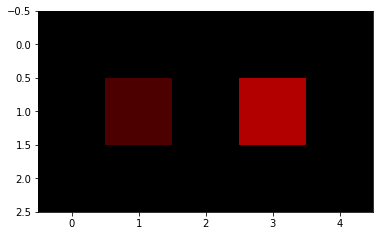

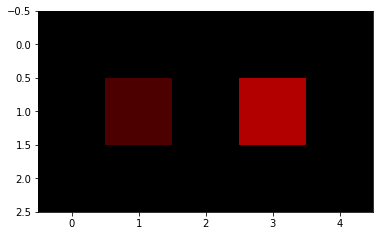

In [8]:
# Settings for domain A (red)
offset_A = 0.3
ratio_A = 0.3
color_A = 0
std_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A, std=std_A)
dataloader_A = DataLoader(dataset_A, batch_size=64, shuffle=True)

# Settings for domain B (green)
offset_B = 0.3
ratio_B = 0.7
color_B = 0
std_B = 0
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B, std=std_B)
dataloader_B = DataLoader(dataset_B, batch_size=64, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

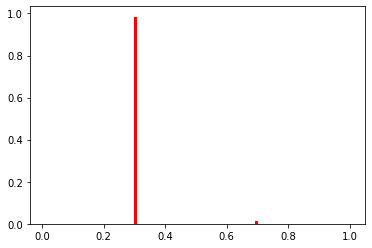

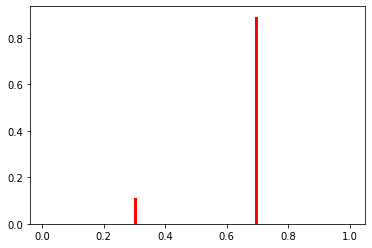

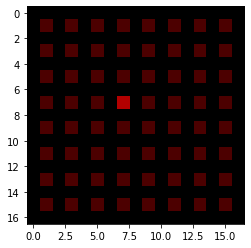

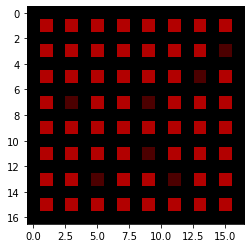

In [9]:
def plot_hist(data):
    data = data.permute(1,0,2,3).view(3,-1).cpu()
    for i, c in enumerate(('r', 'g', 'b')):
        plt.hist(data[i], weights=torch.ones(len(data[i]))/len(data[i]), 
                 color=c, bins=100, range= (0.01, 1))
        x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
#     print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
#     print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64])
    visualize_img_batch(data_B[:64])
    break

## The training loop

In [20]:
# Initialize the networks
weight_network_A = TrivialWeightNet().cuda()
weight_network_B = TrivialWeightNet().cuda()
discriminator = Discriminator(batch_size=64).cuda()

# Initialize the optimizers
lr = 0.001
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Store values
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

example_d_real = []
example_d_sample = []

penalties = []
variances = []

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):

        # The weighting process
        w = torch.sigmoid(weight_network_A(real_A)).cuda()
        v = torch.sigmoid(weight_network_B(real_B)).cuda()

        # The loss function --------------------------------------------------------------------------------
        
        # For storing purposes
        Lmin  = (discriminator(real_A) * 0.5*(1 + w.detach())).sum().detach()
        Lplus = (discriminator(real_B) * 0.5*(1 + v.detach())).sum().detach()
        
        activation_penalty_A = (discriminator(real_B)**2 - 1).sum()
        activation_penalty_B = (discriminator(real_B.detach())**2 - 1).sum()
        lambda_penalty = 1
        
        # The losses that are used for backprop
        loss_d = ((discriminator(real_B)) * 0.5*(1 + v.detach())).sum() - \
                 ((discriminator(real_A)) * 0.5*(1 + w.detach())).sum() + \
                 lambda_penalty*(activation_penalty_A + activation_penalty_B)

        # A +, B -
        
        loss_w = (((discriminator(real_A)).detach() * 0.5*(1 + w)).sum() - \
                 ((discriminator(real_B)).detach() * 0.5*(1 + v)).sum())**2

        # (w.sum() - v.sum())**2
        
        # ---------------------------------------------------------------------------------------------------

        # Backward        
#         optimizer_w.zero_grad()
#         loss_w.backward()
#         optimizer_w.step()       
        
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]
        
        penalties += [(activation_penalty_A.item(), activation_penalty_B.item())]
        
        w_a = weight_network_A(dataset_A.example_imgs.cuda())
        w_b = weight_network_B(dataset_B.example_imgs.cuda())
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        
        d_a = discriminator(real_A)
        d_b = discriminator(real_B)   
        example_d_sample += [(d_a.item(), d_b.item())] # Store examples in a list
        
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('step', i, 'loss_d: ', loss_d.item(), 'loss_w: ', loss_w.item())

step 0 loss_d:  -1.8304457664489746 loss_w:  0.005009645130485296
step 500 loss_d:  -876.9752807617188 loss_w:  765665.1875
step 1000 loss_d:  -9860.46875 loss_w:  97195680.0
step 1500 loss_d:  -23235.130859375 loss_w:  540114048.0
step 2000 loss_d:  -36851.60546875 loss_w:  1453322624.0
step 2500 loss_d:  -50478.46484375 loss_w:  2968221952.0
step 3000 loss_d:  -50824.2734375 loss_w:  3045602048.0
step 3500 loss_d:  -62555.00390625 loss_w:  5909626368.0
step 4000 loss_d:  -68425.65625 loss_w:  6013570048.0
step 4500 loss_d:  -87810.71875 loss_w:  8324969984.0
step 5000 loss_d:  37171.296875 loss_w:  6269809152.0
step 5500 loss_d:  -104422.0 loss_w:  12320456704.0
step 6000 loss_d:  -115500.8125 loss_w:  14152358912.0


KeyboardInterrupt: 

In [24]:
weight_network_A = weight_network_A.eval().cpu()
weight_network_B = weight_network_B.eval().cpu()
discriminator = discriminator.eval().cpu()

### Interpretation

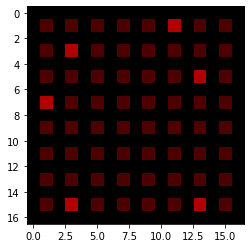

True ratio domain A 0.1


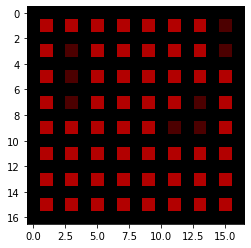

True ratio domain B 0.9


In [25]:
visualize_img_batch(real_A[:64])
print('True ratio domain A {}'.format(ratio_A))
# plot_hist(real_A)

visualize_img_batch(real_B[:64])
print('True ratio domain B {}'.format(ratio_B))
# plot_hist(real_B)

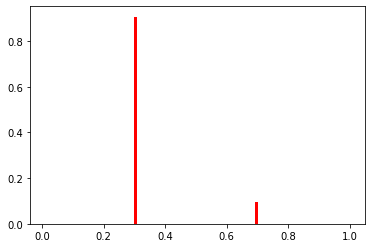

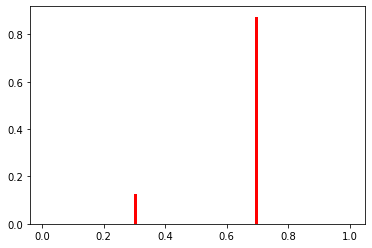

In [26]:
plot_hist(real_A)

plot_hist(real_B)

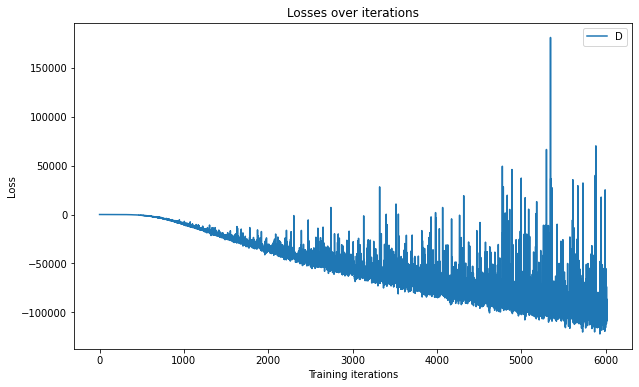

In [27]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_d)
plt.legend(['D'])
plt.show()

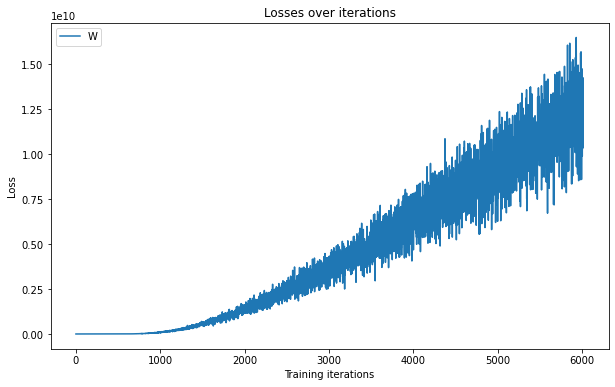

In [28]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

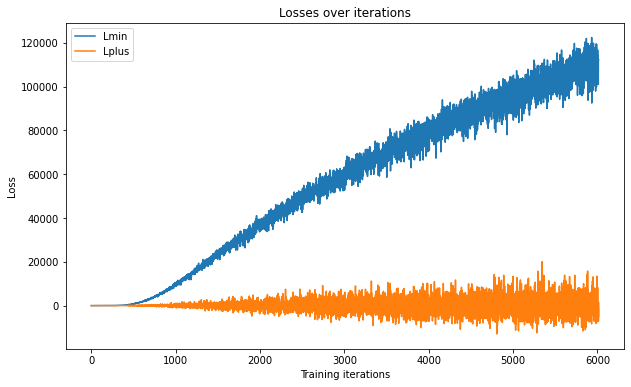

In [29]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

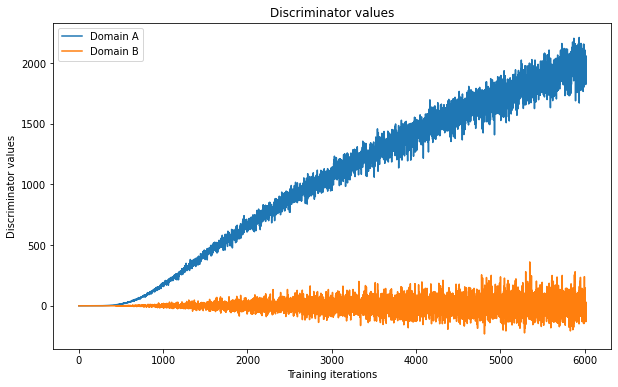

In [30]:
plt.figure(figsize=(10,6))
plt.title('Discriminator values')
plt.plot(torch.Tensor(example_d_sample)[:, 0])
plt.plot(torch.Tensor(example_d_sample)[:, 1])
plt.legend(['Domain A', 'Domain B'])
plt.ylabel('Discriminator values')
plt.xlabel('Training iterations')
plt.show()

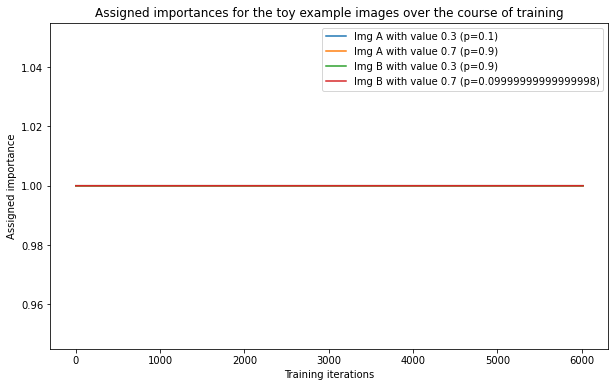

In [31]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

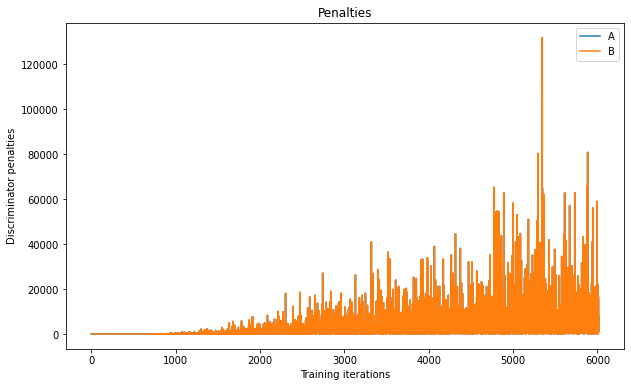

In [32]:
plt.figure(figsize=(10,6))
plt.title('Penalties')
plt.plot(torch.Tensor(penalties)[:, 0])
plt.plot(torch.Tensor(penalties)[:, 1])
plt.legend(['A', 'B'])
plt.ylabel('Discriminator penalties')
plt.xlabel('Training iterations')
plt.show()